# Skills keywords

Objective: identifying skills keywords from job descritions with basic NLP techniques.

In [102]:
import matplotlib.pyplot as plt
import nltk
#from nltk.corpus import stopwords
import pandas as pd
from wordcloud import WordCloud#, STOPWORDS

## Data

The file `job-description-english.xlsx` is our dataset. It contains requirements extracted from 23 job descriptions posted on LinkedIn. Although the jobs were from diverse industries (e.g. utilites, healthcare, marketing, consultant), they all are for "senior data scientist" positions in United States.

In [103]:
df = pd.read_excel('job-description-english.xlsx', header=None)
df.columns = ['job_description']

In [104]:
# Let's see a few descriptions to have a grasp of the data
print(df.iloc[0,0])
print(df.iloc[1,0])
print(df.iloc[2,0])

At least 4 years of relevant data science, analytics or machine learning professional experience
Experience in data engineering and feature preparation
Experience in developing machine learning models using a variety of techniques (including regression, classification, clustering, time series, NLP)
Track record of successfully developing and implementing ML models
Experience working with large datasets (healthcare-relevant datasets are a plus)
Interest in being an early DS/ML team member, with the technical ability to develop high value models independently while prioritizing collaboration with your teammates and stakeholders to ensure successful design and implementation
Motivated to build relationships with teammates and stakeholders, and increase data literacy and expertise throughout the organization
Passionate about improving healthcare
Bonus: experience working with large healthcare or healthcare related data sets
5+ years experience with data science, analytics, and ML tooling
P

#### Heads Up

Things to be know in advance:
- not all phrase ends with a final dot;
- not all phrare starts with a capital letter (ex: DS/ML);
- experience is portraiyed with a number (e.g. +5 years experience);
- a lot of keyword are irrelevant (e.g. experience, ability);
- true keywords will contains Python, SQL and Tensor Flow

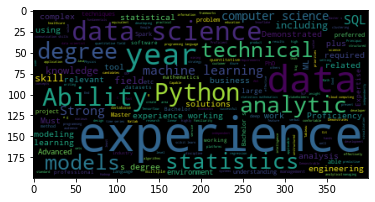

In [105]:
# Round 1: raw data
long_string = df['job_description'].str.cat(sep=' ')
wordcloud = WordCloud().generate(long_string)
plt.imshow(wordcloud)

#### Round 1: no treatment

The wordcloud based on raw text is not good. Although there are a few relevant useful like `Python`, the majority of words are irrelevant, like `experience`.

## Data cleaning

There are a few steps involved in data cleaning:

- obtain tokens from the corpus;
- convert all words to lowercase;
- remove stopwords (e.g. 'to', 'and', 'experience');
- unify the words variations (i.e. stemming);
- undue the verbal conjugation (i.e. lemmatization);

In [106]:
# Isolate each word from the string in token.
tokens = nltk.tokenize.word_tokenize(long_string)

tokens[:5]

['At', 'least', '4', 'years', 'of']

In [107]:
# Lowercase all tokens
long_string_low = [i.lower() for i in tokens]
long_string_low[:5]

['at', 'least', '4', 'years', 'of']

In [108]:
# Using nltk default stopwords.
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

print(stopwords[:5])

['i', 'me', 'my', 'myself', 'we']


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kenji\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [109]:
# Removing stopwords
long_string_low_clean = [i for i in long_string_low if not i in stopwords]
long_string_low_clean[:5]

['least', '4', 'years', 'relevant', 'data']

In [110]:
'''
# Stemming
ps = nltk.stem.SnowballStemmer(language='english')

long_string_low_clean = [ps.stem(i) for i in long_string_low_clean]
long_string_low_clean[:5]
'''

print('It turns out stemming was a bad choice because it reduced "too much" (ex: "experience" became "exper", "relevant" became "relev"). The result became too complex for post analysis.')

It turns out stemming was a bad choice because it reduced "too much" (ex: "experience" became "exper", "relevant" became "relev"). The result became too complex for post analysis.


In [111]:
# Lemmatization
nltk.download('wordnet')
lem = nltk.stem.WordNetLemmatizer()

long_string_low_clean = [lem.lemmatize(i, pos='n') for i in long_string_low_clean]
long_string_low_clean = [lem.lemmatize(i, pos='v') for i in long_string_low_clean]
long_string_low_clean = [lem.lemmatize(i, pos='a') for i in long_string_low_clean]
long_string_low_clean = [lem.lemmatize(i, pos='r') for i in long_string_low_clean]
long_string_low_clean = [lem.lemmatize(i, pos='s') for i in long_string_low_clean]
long_string_low_clean[:5]

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Kenji\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['least', '4', 'year', 'relevant', 'data']

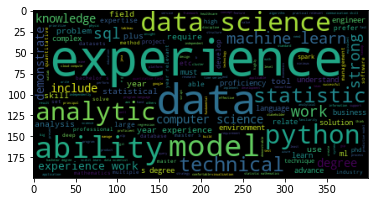

In [112]:
# Round 2: basic preprocessing.
wordcloud = WordCloud().generate(' '.join(long_string_low_clean))
plt.imshow(wordcloud)

#### Round 2: basic preprocessing

The results are not good either. For starters, the stopwords were not even a problem in the first round, so it is expected that the round 2's result should not be much better.

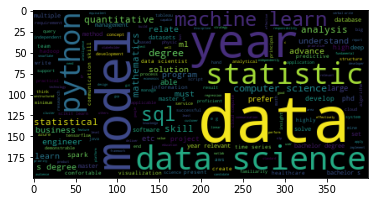

In [113]:
# Removing context relevant stopwords.
list_custom_words = ['abil'
                    ,'ability'
                    ,'analytics'
                    ,'complex'
                    ,'demonstr'
                    ,'demonstrate'
                    ,'environment'
                    ,'experi'
                    ,'experience'
                    ,'expertise'
                    ,'field'
                    ,'include'
                    ,'industry'
                    ,'knowledge'
                    ,'language'
                    ,'plus'
                    ,'preferred'
                    ,'problem'
                    ,'professional'
                    ,'profici'
                    ,'proficiency'
                    ,'requir'
                    ,'require'
                    ,'required'
                    ,'solutions'
                    ,'strong'
                    ,'technique'
                    ,'technical'
                    ,'tool'
                    ,'use'
                    ,'using'
                    ,'work'
                    ,'working'
                    
]

# Removing more stopwords
long_string_low_cleaner = [i for i in long_string_low_clean if not i in list_custom_words]

# Round 3: advanced preprocessing.
wordcloud = WordCloud().generate(' '.join(long_string_low_cleaner))
plt.imshow(wordcloud)

#### Round 3: custom preprossing

From the results it is possible to distinguish the first keywords: `python`, `statistic`, `machine learn`, `computer science`, `sql`, `model`. Nonethless, the bigget keyword still is `data`, which could lead us to common terms like `data cleaning` or `data driven`.

## Data extraction

In [177]:
from selenium import webdriver
from bs4 import BeautifulSoup
import time
import string

In [180]:
string.punctuation


'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [115]:
def url_to_soup(url):
    """"
    Step 1: extract url's html into soup object.
    """
    driver = webdriver.Chrome()
    driver.get(url)

    time.sleep(3)
    html = driver.page_source
    soup = BeautifulSoup(html, "html.parser")
    driver.close()
    return soup

# Check.
#url = "https://www.linkedin.com/jobs/search?keywords=Senior%20Data%20Scientist&location=United%20States"
#soup = url_to_soup(url)

In [116]:
def soup_to_jobs(soup):
    """"
    Step 2: get all jobs specific url from the LinkedIn general search.
    """
    descriptions = soup.find_all("a", class_="base-card__full-link absolute top-0 right-0 bottom-0 left-0 p-0 z-[2]")

    list_job_href = [i.get('href') for i in descriptions]
    print(f"Jobs found: {len(list_job_href)}")
    
    return list_job_href

# Check.
#list_job_href = soup_to_jobs(soup)

In [117]:
def jobs_to_description(list_href):
    """
    Step 3: extract raw job description from job posting.
    """
    list_title = []
    list_description = []
    
    for href in list_href:
        soup = url_to_soup(href)
        list_title.append(soup.find('title').string)
        list_description.append(soup.find('div', class_='show-more-less-html__markup show-more-less-html__markup--clamp-after-5').get_text())

    df = pd.DataFrame({'title': list_title, 'href': list_href, 'description':list_description})
    return df

# Check
#df = jobs_to_description(list_job_href[:3])

In [203]:
def pipeline_extract():
    """
    Step 1 + 2 + 3: encapsulate all exctraction steps.
    """
    list_url = [
        'https://www.linkedin.com/jobs/search?keywords=Senior%20Data%20Scientist&location=United%20States&position=1&pageNum=0',
        'https://www.linkedin.com/jobs/search?keywords=Data%20Science&location=United%20States&position=1&pageNum=0',
        'https://www.linkedin.com/jobs/search?keywords=Data%20Scientist%20III&location=United%20States&position=1&pageNum=0',
        'https://www.linkedin.com/jobs/search?keywords=Data%20Scientist%20&location=United%20States&position=1&pageNum=0'
    ]


    for i in list_url:
        soup = url_to_soup(i)
        list_job_href = soup_to_jobs(soup)
        df = jobs_to_description(list_job_href)
    
    return df

In [205]:
df_raw = pipeline_extract()

Jobs found: 25
Jobs found: 25
Jobs found: 25
Jobs found: 25


In [206]:
df_raw.sample(5)
df_raw.to_csv('tes.csv', index=False)

## Data preprocessing

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kenji\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Kenji\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


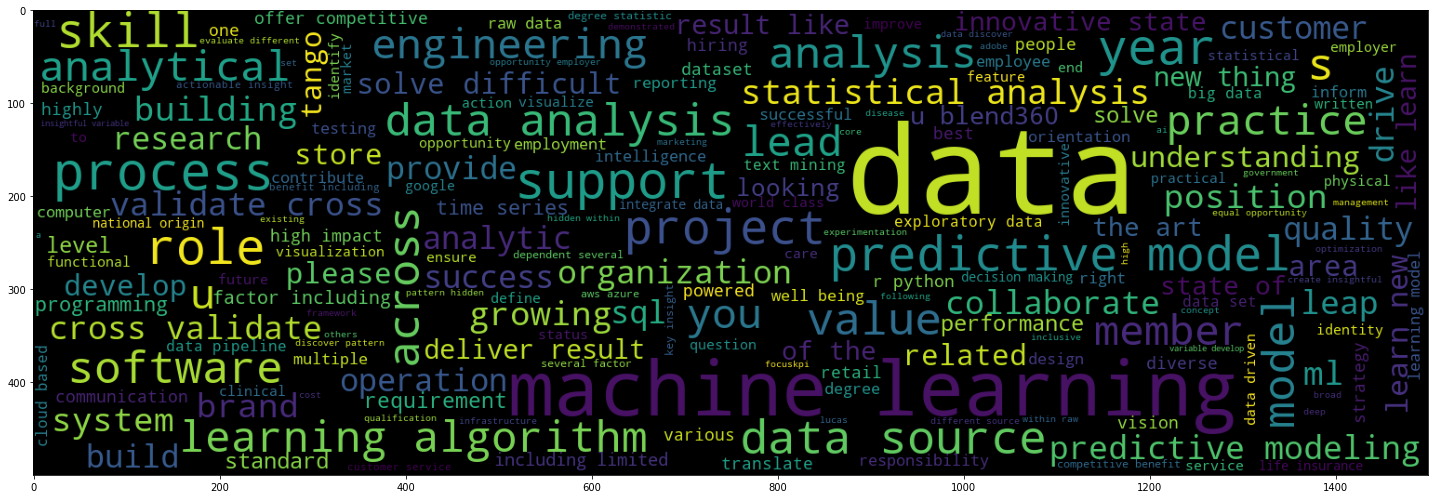

In [199]:
def basic_preprocessing(df):
    # "squash" description column into a single long string.
    long_string = df_raw['description'].str.cat(sep=' ')
    tokens = nltk.tokenize.word_tokenize(long_string)

    # Lowercase all tokens
    tokens = [i.lower() for i in tokens]
    tokens[:5]

    # Remove punctuation
    tokens = [i for i in tokens if i not in string.punctuation]

    # Using nltk default stopwords.
    nltk.download('stopwords')
    stopwords = nltk.corpus.stopwords.words('english')
    tokens = [i for i in tokens if not i in stopwords]

    # Stemming
    #ps = nltk.stem.SnowballStemmer(language='english')
    #tokens = [ps.stem(i) for i in tokens]

    # Lemmatization
    nltk.download('wordnet')
    lem = nltk.stem.WordNetLemmatizer()
    tokens = [lem.lemmatize(i) for i in tokens]

    wordcloud = WordCloud(width=1500, height=500, stopwords=list_custom_words).generate(' '.join(tokens))
    plt.figure(figsize=(25,10))
    plt.imshow(wordcloud)
    return tokens

tokens = basic_preprocessing(df)

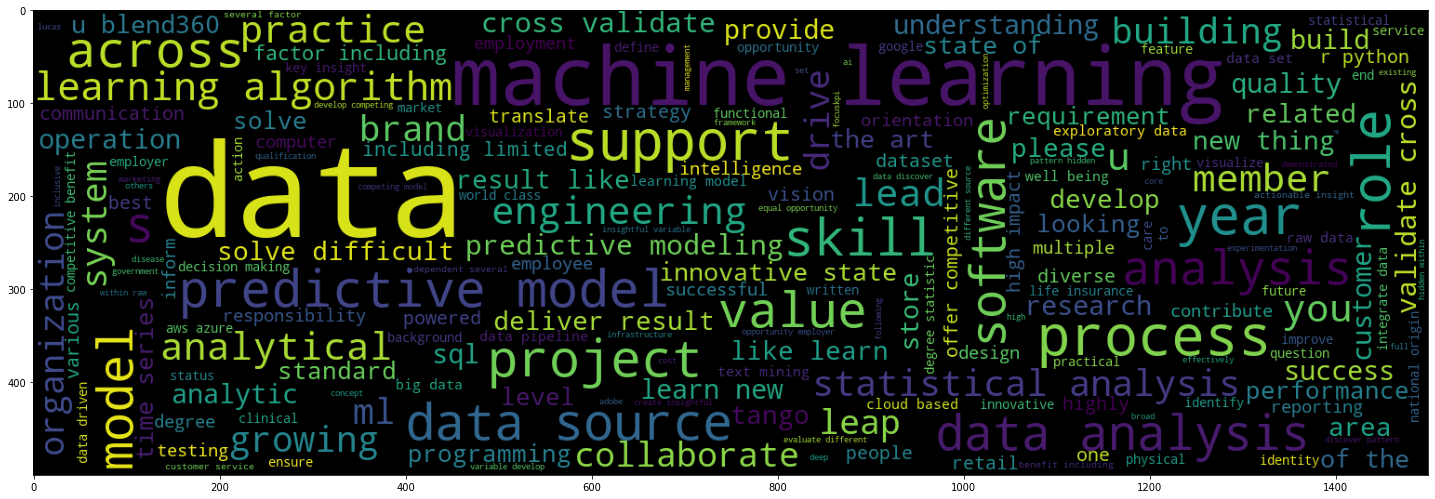

In [200]:
def advanced_preprocessing(tokens):
    # Removing context relevant stopwords.
    list_custom_words = pd.read_csv('to_be_omitted.csv', header=None, index_col=False).iloc[:, 0].tolist()

    wordcloud = WordCloud(width=1500, height=500, stopwords=list_custom_words).generate(' '.join(tokens))
    plt.figure(figsize=(25,10))
    plt.imshow(wordcloud)


advanced_preprocessing(tokens)